In [8]:
import jax
import jax.random as jr

import numpy as np

In [9]:
import matplotlib.pyplot as plt

In [10]:
import gpjax as gpx

import jax.scipy as jspy

In [11]:
# Enable Float64 for more stable matrix inversions.
from jax import config
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import install_import_hook
import matplotlib as mpl
import matplotlib.pyplot as plt

#from examples.utils import (
#    clean_legend,
#    use_mpl_style,
#)

config.update("jax_enable_x64", True)


with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx


key = jr.key(123)

# set the default style for plotting
#use_mpl_style()

cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

In [12]:
import numpyro
import numpyro.distributions as dist
MultivariateNormal = dist.MultivariateNormal
from numpyro.distributions import Normal
import optax

# Import GSM                                                                                                                                                  
#import sys
#sys.path.append('../gsmvi//')
from gsmvi.gsm import GSM
from gsmvi.bbvi import ADVI, ADVI_LR, ADVI_Factorized, Scorenorm, Fishernorm

from gsmvi.bam_dc import BAM
from gsmvi.gsm import GSM
from gsmvi.pbam import PBAM # PBAM_fullcov
from gsmvi.pgsm import PGSM
from gsmvi.monitors import KLMonitor

from gsmvi.monitors import KLMonitor as Monitor
from time import time

In [6]:
n = 100
noise = 0.3

key, subkey = jr.split(key)
x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(subkey, shape=signal.shape) * noise

D = gpx.Dataset(X=x, y=y)

xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = f(xtest)


n = 100
noise = 0.3

key, subkey = jr.split(key)
x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(subkey, shape=signal.shape) * noise

D = gpx.Dataset(X=x, y=y)

xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = f(xtest)

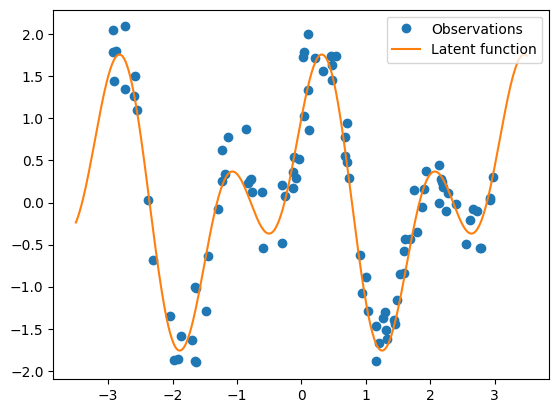

In [6]:
#plt.scatter(xtest, ytest)
fig, ax = plt.subplots()
ax.plot(x, y, "o", label="Observations", color=cols[0])
ax.plot(xtest, ytest, label="Latent function", color=cols[1])
ax.legend(loc="best")

In [7]:
mean = gpx.mean_functions.Zero()
kernel = gpx.kernels.RBF()
prior = gpx.gps.Prior(mean_function = mean, kernel = kernel)
likelihood = gpx.likelihoods.Gaussian(num_datapoints = 123)

posterior = prior * likelihood

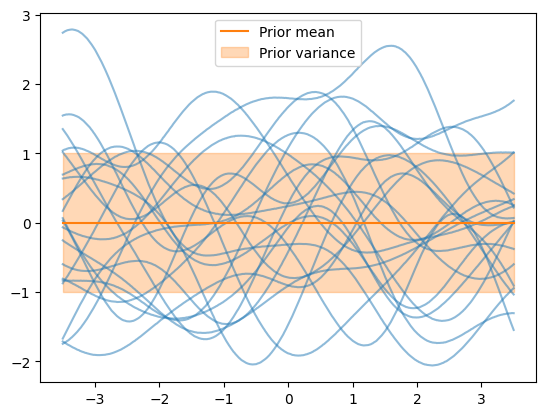

In [8]:
prior_dist = prior.predict(xtest)

prior_mean = prior_dist.mean()
prior_std = prior_dist.variance()
samples = prior_dist.sample(seed=key, sample_shape=(20,))


fig, ax = plt.subplots()
ax.plot(xtest, samples.T, alpha=0.5, color=cols[0], label="")
ax.plot(xtest, prior_mean, color=cols[1], label="Prior mean")
ax.fill_between(
    xtest.flatten(),
    prior_mean - prior_std,
    prior_mean + prior_std,
    alpha=0.3,
    color=cols[1],
    label="Prior variance",
)
ax.legend(loc="best")
#ax = clean_legend(ax)

In [25]:
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n)
posterior = prior * likelihood


In [26]:
print(-gpx.objectives.conjugate_mll(posterior, D))


133.12452241131825


In [27]:
opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    # we use the negative mll as we are minimising
    objective=lambda p, d: -gpx.objectives.conjugate_mll(p, d),
    train_data=D,
)

print(-gpx.objectives.conjugate_mll(opt_posterior, D))

Optimization terminated successfully.
         Current function value: 55.611501
         Iterations: 13
         Function evaluations: 20
         Gradient evaluations: 20
55.61150126594523


In [28]:
latent_dist = opt_posterior.predict(xtest, train_data=D)
predictive_dist = opt_posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

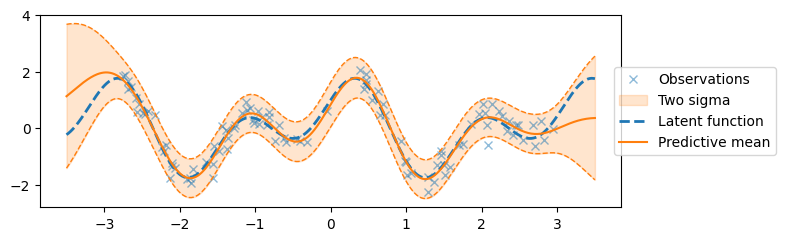

In [29]:
fig, ax = plt.subplots(figsize=(7.5, 2.5))
ax.plot(x, y, "x", label="Observations", color=cols[0], alpha=0.5)
ax.fill_between(
    xtest.squeeze(),
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    label="Two sigma",
    color=cols[1],
)
ax.plot(
    xtest,
    predictive_mean - 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    xtest,
    predictive_mean + 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    xtest, ytest, label="Latent function", color=cols[0], linestyle="--", linewidth=2
)
ax.plot(xtest, predictive_mean, label="Predictive mean", color=cols[1])
ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))

In [175]:
import jax
import jax.numpy as jnp 
import jax.random as jrnd

def elliptical_slice_jax(x0, log_lh_func, chol, num_samples, rng_key):
    """
    Jax implementation of ESS
    """

    @jax.jit
    def ess_step_condfun(state):
        x, new_x, nu, thresh, lower, upper, rng_key = state
        llh = log_lh_func(new_x)
        return log_lh_func(new_x) < thresh

    @jax.jit
    def ess_step_bodyfun(state):
        x, new_x, nu, thresh, lower, upper, rng_key = state
        theta_rng, rng_key = jrnd.split(rng_key, 2)
        theta = jrnd.uniform(theta_rng, minval=lower, maxval=upper)
        new_x = x * jnp.cos(theta) + nu * jnp.sin(theta)
        lower, upper = jax.lax.cond(theta < 0, lambda : (theta, upper), lambda : (lower, theta))
        return x, new_x, nu, thresh, lower, upper, rng_key

    @jax.jit
    def ess_step(x, rng_key):
        nu_rng, u_rng, theta_rng, rng_key = jrnd.split(rng_key, 4)
        nu = chol.T @ jrnd.normal(nu_rng, shape=x.shape)
        u = jrnd.uniform(u_rng)
        thresh = log_lh_func(x) + jnp.log(u)
        theta = jrnd.uniform(theta_rng, minval=0, maxval=2*jnp.pi)
        upper = theta
        lower = theta - 2 * jnp.pi
        new_x = x * jnp.cos(theta) + nu * jnp.sin(theta)
        _, new_x, _, _, _, _, _ = jax.lax.while_loop(
          ess_step_condfun,
          ess_step_bodyfun,
          (x, new_x, nu, thresh, lower, upper, rng_key)
        )
        return new_x

    @jax.jit
    def scanfunc(state, xs):
        x, rng_key = state
        step_key, rng_key = jrnd.split(rng_key, 2)
        x = ess_step(x, step_key)
        return (x, rng_key), x

    _, samples = jax.lax.scan(scanfunc, (x0, rng_key), None, num_samples)

    return samples


# Synthetic Poisson example

$$
\log f \sim \text{GP}(0, k) \\
y_n \sim \text{Pois}(e^f_n)
$$

The target distribution is:
$$
p(f) = N(0, \Sigma) \prod_{n=1}^N p(y_n; f)
$$

In [13]:
# length scale 
ls = 1
# signal variance
s_f = 1

kernel_rbf = lambda x, y: s_f**2 * jnp.exp(-0.5 * jnp.linalg.norm(x - y)**2 / ls**2)

kernel_rbf = jax.jit(kernel_rbf)

In [14]:
kernel_rbf(jnp.zeros(2), jnp.ones(2))

Array(0.36787944, dtype=float64)

In [15]:
#D = 1
D = 100
#xlim = jnp.linspace(0, 100, D)
xlim = jnp.linspace(-3, 3, D)


kernel_matrix = jax.vmap(jax.vmap(kernel_rbf, in_axes=(None, 0)), in_axes=(0, None))(xlim, xlim)+ 1e-6*np.eye(D)

In [16]:
jnp.linalg.cond(kernel_matrix)

Array(37635100.9734591, dtype=float64)

In [17]:
key = jr.key(1234)
#key, subkey = jr.split(key)

# log f ~ GP
g = jr.multivariate_normal(key, mean=jnp.zeros(D), cov=kernel_matrix) # + 1e-6*np.eye(D))
# Poisson rate
f = jnp.exp(g)
# observed counts
y = jr.poisson(key, lam=f)
#y = jr.multivariate_normal(key, mean=g, cov=0.01*jnp.eye(D))

In [18]:
ref_samples = jr.multivariate_normal(key, mean=jnp.zeros(D), cov=kernel_matrix, shape=(100,D))

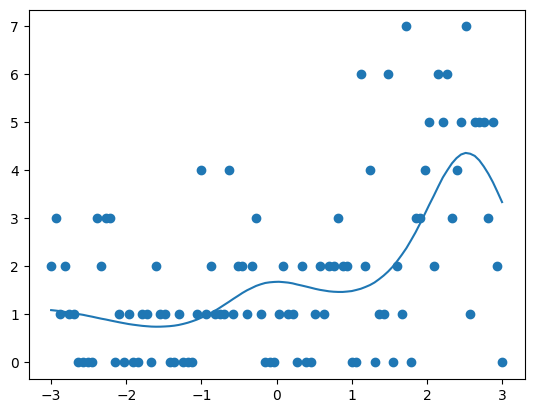

In [19]:
plt.plot(xlim, f)
plt.scatter(xlim, y)

In [21]:
z = jnp.zeros(D)

def lp(z):
    # global variables: data y, prior kernel_matrix
    lp = jspy.stats.multivariate_normal.logpdf(z, mean=jnp.zeros(D), cov=kernel_matrix)
    lp += jspy.stats.poisson.logpmf(y, jnp.exp(z)).sum()
    #lp += jspy.stats.multivariate_normal.logpdf(y, mean=z, cov=0.1*jnp.eye(D)).sum()
    return lp

lp_g = jax.jit(jax.grad(lp, argnums=0))

lp_vmap = lambda x: jax.vmap(lp, in_axes=0)(x)
lp_g_vmap = lambda x: jax.vmap(lp_g, in_axes=0)(x)

In [22]:
lp(g)

Array(301.21350906, dtype=float64)

In [7]:
alg = ADVI(D, lp_vmap)
key = jax.random.PRNGKey(2)
batch_size = 100
niter = 10_000
nprint = 10
lr = 1e-2

monitor_advi = KLMonitor(batch_size=32, ref_samples=None, checkpoint=10, store_params_iter=10)
opt = optax.adam(learning_rate=lr)

%time meanfit_advi, covfit_advi, losses = alg.fit(key, opt, batch_size=batch_size, niter=niter, nprint=nprint, \
                                monitor=monitor_advi)

NameError: name 'D' is not defined

In [152]:
alg = ADVI_Factorized(D, lp_vmap)
key = jax.random.PRNGKey(2)
batch_size = 100
niter = 10_000
nprint = 10
lr = 1e-2

monitor_advi_diag = KLMonitor(batch_size=32, ref_samples=None, checkpoint=10, store_params_iter=10)
opt = optax.adam(learning_rate=lr)

%time meanfit_advi_diag, covfit_advi_diag, losses_diag = alg.fit(key, opt, batch_size=batch_size, niter=niter, nprint=nprint, \
                                monitor=monitor_advi_diag)

Iteration 0 of 10000
Iteration 1000 of 10000
Iteration 2000 of 10000
Iteration 3000 of 10000
Iteration 4000 of 10000
Iteration 5000 of 10000
Iteration 6000 of 10000
Iteration 7000 of 10000
Iteration 8000 of 10000
Iteration 9000 of 10000
Iteration 10000 of 10000
CPU times: user 3min 51s, sys: 3min 46s, total: 7min 37s
Wall time: 40.7 s


In [156]:
rank = 32
alg = ADVI_LR(D, rank, lp_vmap, jit_compile=True)
key = jax.random.PRNGKey(2)
batch_size = 100
niter = 10_000
nprint = 10
lr = 1e-2

monitor_advi_lr = KLMonitor(batch_size=32, ref_samples=None, checkpoint=10, store_params_iter=10)
opt = optax.adam(learning_rate=lr)

%time meanfit_advi_lr, psi_advi_lr, lambda_advi_lr, losses_lr = alg.fit(key, opt, batch_size=batch_size, niter=niter, nprint=nprint, \
                                monitor=monitor_advi_lr)

covfit_advi_lr = lambda_advi_lr @ lambda_advi_lr.T + psi_advi_lr

jit compile True True
Iteration 0 of 10000
Iteration 1000 of 10000
Iteration 2000 of 10000
Iteration 3000 of 10000
Iteration 4000 of 10000
Iteration 5000 of 10000
Iteration 6000 of 10000
Iteration 7000 of 10000
Iteration 8000 of 10000
Iteration 9000 of 10000
Iteration 10000 of 10000
CPU times: user 33.5 s, sys: 21.2 s, total: 54.7 s
Wall time: 20.6 s


In [157]:
covfit_advi_lr = lambda_advi_lr @ lambda_advi_lr.T + psi_advi_lr

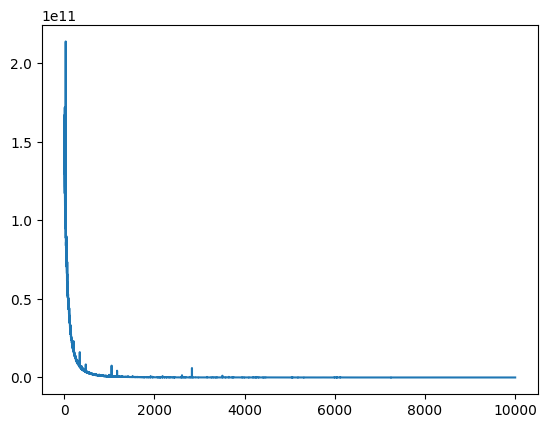

In [159]:
plt.plot(losses_lr)

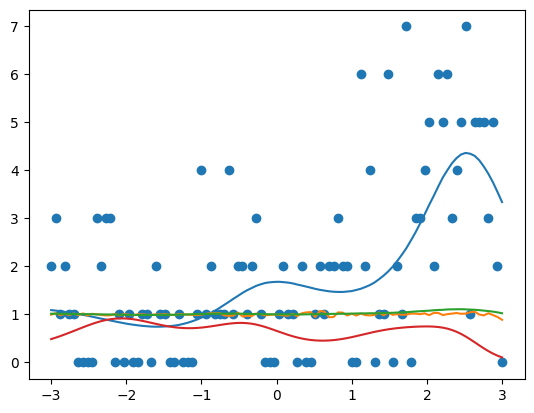

In [160]:
plt.plot(xlim, f)
plt.scatter(xlim, y)
plt.plot(xlim, jnp.exp(meanfit_advi))
plt.plot(xlim, jnp.exp(meanfit_advi_diag))
plt.plot(xlim, jnp.exp(meanfit_advi_lr))

In [24]:
alg = BAM(D, lp_vmap, lp_g_vmap, use_lowrank=True)
key = jax.random.PRNGKey(2)
batch_size = 40
niter = 10_000
nprint = 50

regf = lambda x: D * batch_size #1000#/(1+x)

monitorbam = KLMonitor(batch_size=32, ref_samples=None, checkpoint=10, store_params_iter=10)
# monitor = None
%time meanfit_bam, covfit_bam = alg.fit(key, batch_size=batch_size, niter=niter, regf=regf, nprint=nprint, \
                                monitor=monitorbam, check_goodness=False)

Using lowrank update
use low rank
Iteration 0 of 10000
(100, 41)
Iteration 200 of 10000
Iteration 400 of 10000
Iteration 600 of 10000
Iteration 800 of 10000
Iteration 1000 of 10000
Iteration 1200 of 10000
Iteration 1400 of 10000
Iteration 1600 of 10000
Iteration 1800 of 10000
Iteration 2000 of 10000
Iteration 2200 of 10000
Iteration 2400 of 10000
Iteration 2600 of 10000
Iteration 2800 of 10000
Iteration 3000 of 10000
Iteration 3200 of 10000
Iteration 3400 of 10000
Iteration 3600 of 10000
Iteration 3800 of 10000
Iteration 4000 of 10000
Iteration 4200 of 10000
Iteration 4400 of 10000
Iteration 4600 of 10000
Iteration 4800 of 10000
Iteration 5000 of 10000
Iteration 5200 of 10000
Iteration 5400 of 10000
Iteration 5600 of 10000
Iteration 5800 of 10000
Iteration 6000 of 10000
Iteration 6200 of 10000
Iteration 6400 of 10000
Iteration 6600 of 10000
Iteration 6800 of 10000
Iteration 7000 of 10000
Iteration 7200 of 10000
Iteration 7400 of 10000
Iteration 7600 of 10000
Iteration 7800 of 10000
Ite

[]

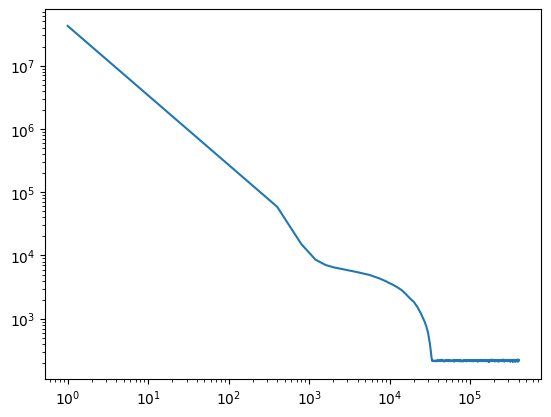

In [25]:
plt.plot(monitorbam.nevals, monitorbam.rkl)
plt.loglog()

[]

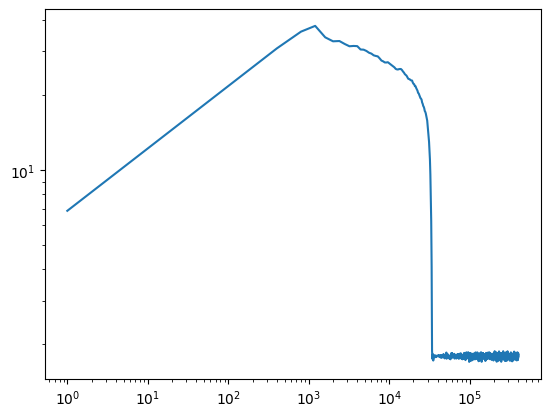

In [26]:
plt.plot(monitorbam.nevals, [jnp.linalg.norm(monitorbam.means[i] - g) for i in range(len(monitorbam.nevals))])
plt.loglog()

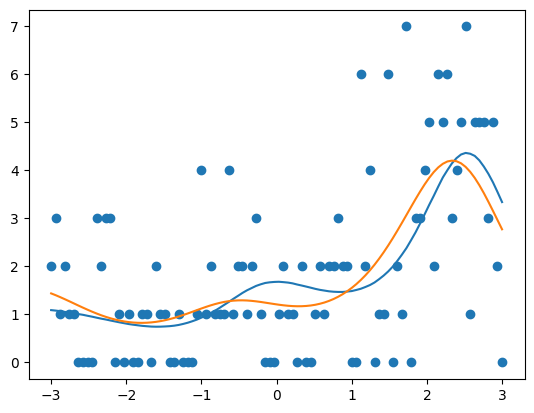

In [28]:
plt.plot(xlim, f)
plt.scatter(xlim, y)
#plt.plot(xlim, jnp.exp(meanfit_advi))
plt.plot(xlim, jnp.exp(meanfit_bam))

In [25]:
ranklr = 32

batch_size = 80
niter = 10_000
pbam = PBAM(D, lp_vmap, lp_g_vmap)
key = jax.random.PRNGKey(2)
nprint = 100
regf = lambda x: D * batch_size #1000#/(1+x)


monitor_pbam = KLMonitor(batch_size=32, ref_samples=None, checkpoint=10, store_params_iter=10)
%time meanfit_pbam, psi, llambda = pbam.fit(key, rank=ranklr, batch_size=batch_size, niter=niter, \
                                  regf=regf, nprint=nprint, \
                                  tolerance=1e-4, eta=1.0, niter_em=501, \
                                  print_convergence=False, monitor=monitor_pbam)

covfit_pbam = np.diag(psi) + llambda@llambda.T


Iteration 0 of 10000. Time taken :  4.291534423828125e-06
jit pbam update
jit psi/llambda update
compiled
time for first 10 iterations :  0.2080240249633789
Iteration 100 of 10000. Time taken :  0.6589062213897705
Iteration 200 of 10000. Time taken :  1.105882167816162
Iteration 300 of 10000. Time taken :  1.5623109340667725
Iteration 400 of 10000. Time taken :  2.006777048110962
Iteration 500 of 10000. Time taken :  2.458327054977417
Iteration 600 of 10000. Time taken :  2.9042270183563232
Iteration 700 of 10000. Time taken :  3.3586831092834473
Iteration 800 of 10000. Time taken :  3.8126590251922607
Iteration 900 of 10000. Time taken :  4.2585790157318115
Iteration 1000 of 10000. Time taken :  4.724468946456909
Iteration 1100 of 10000. Time taken :  5.215924978256226
Iteration 1200 of 10000. Time taken :  5.688568115234375
Iteration 1300 of 10000. Time taken :  6.182675123214722
Iteration 1400 of 10000. Time taken :  6.647345304489136
Iteration 1500 of 10000. Time taken :  7.1032681

Text(0.5, 0, '# gradient evals')

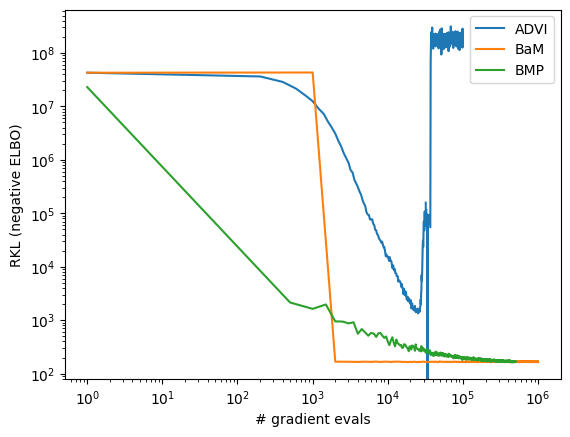

In [169]:
plt.plot(monitor_advi.nevals, monitor_advi.rkl, label="ADVI")

plt.plot(monitorbam.nevals, monitorbam.rkl, label="BaM")

plt.plot(monitor_pbam.nevals, monitor_pbam.rkl, label="BMP")
plt.loglog()

plt.legend()

plt.ylabel("RKL (negative ELBO)"); plt.xlabel("# gradient evals")

Text(0.5, 0, '# gradient evals')

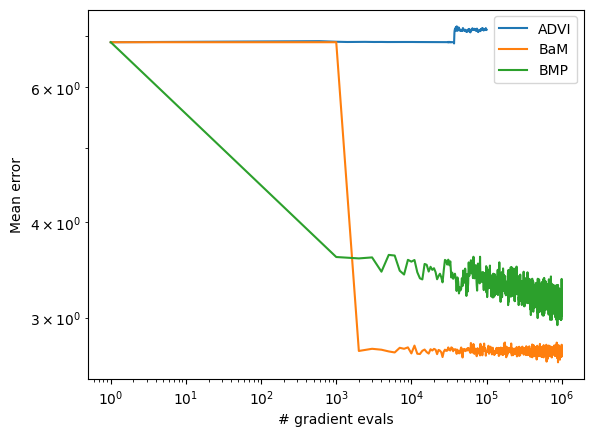

In [195]:
plt.plot(monitor_advi.nevals, [jnp.linalg.norm(monitor_advi.means[i] - g) for i in range(len(monitor_advi.nevals))], label="ADVI")


plt.plot(monitorbam.nevals, [jnp.linalg.norm(monitorbam.means[i] - g) for i in range(len(monitorbam.nevals))], label="BaM")

plt.plot(monitorbam.nevals, [jnp.linalg.norm(monitor_pbam.means[i] - g) for i in range(len(
    monitor_pbam.nevals))], label="BMP")


plt.loglog()

plt.legend()

plt.ylabel("Mean error"); plt.xlabel("# gradient evals")

Text(0.5, 0, 'Time')

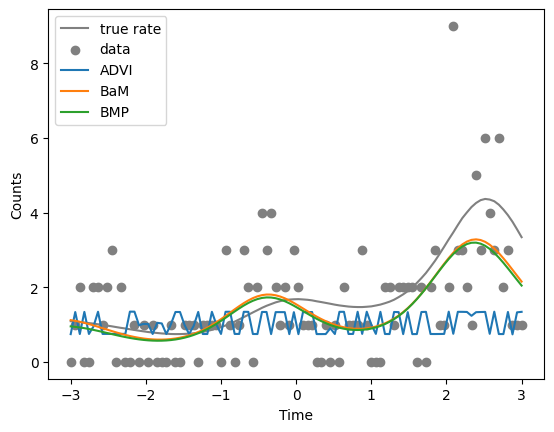

In [174]:
plt.plot(xlim, f, label="true rate", c="gray")
plt.scatter(xlim, y, label="data", c="gray")
plt.plot(xlim, jnp.exp(meanfit_advi), label="ADVI")
plt.plot(xlim, jnp.exp(meanfit_bam), label="BaM")
plt.plot(xlim, jnp.exp(meanfit_pbam), label="BMP")

plt.legend()

plt.ylabel("Counts"); plt.xlabel("Time")

In [189]:
num_samples = 100_000
z = jnp.zeros(D)
chol = jnp.eye(D)

%time samples_ess = elliptical_slice_jax(z, lp, chol, num_samples, key)

CPU times: user 38.7 s, sys: 410 ms, total: 39.1 s
Wall time: 39.2 s


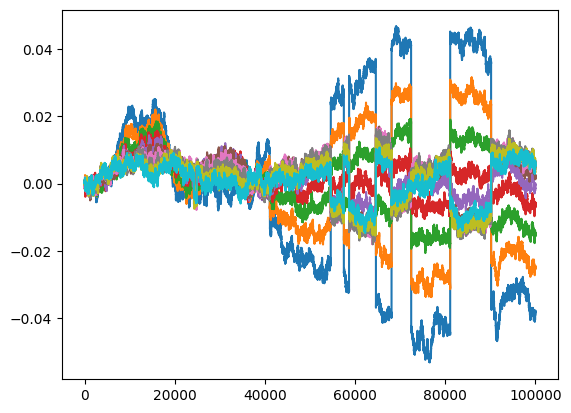

In [190]:
for d in range(10):
    plt.plot(samples_ess[:, d])

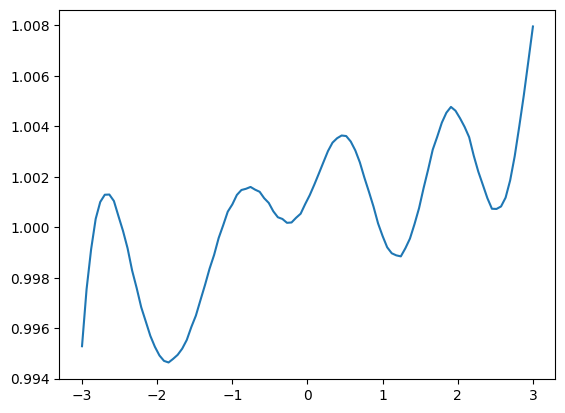

In [191]:
plt.plot(xlim, jnp.exp(samples_ess[20_000:].mean(0)))

Text(0.5, 0, 'Time')

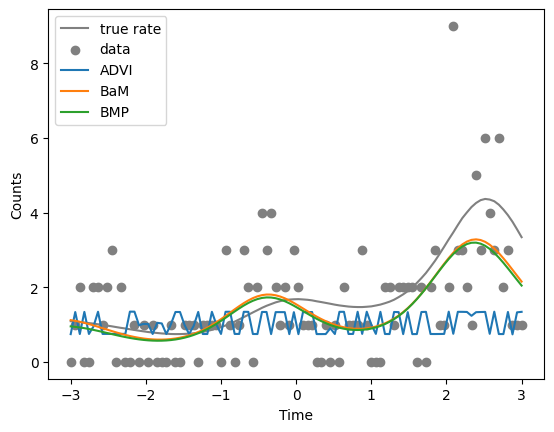

In [192]:
plt.plot(xlim, f, label="true rate", c="gray")
plt.scatter(xlim, y, label="data", c="gray")
#plt.plot(xlim, jnp.exp(samples_ess[20_000:].mean(0)))

plt.plot(xlim, jnp.exp(meanfit_advi), label="ADVI")
plt.plot(xlim, jnp.exp(meanfit_bam), label="BaM")
plt.plot(xlim, jnp.exp(meanfit_pbam), label="BMP")

plt.legend()

plt.ylabel("Counts"); plt.xlabel("Time")

# Coal mining disasters

In [46]:
import rdatasets

In [47]:
df = rdatasets.data("boot", "coal")

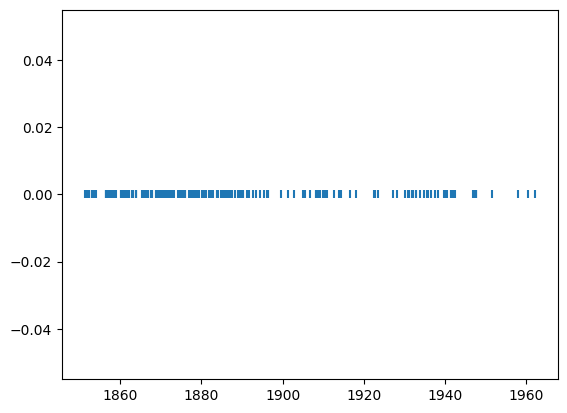

In [48]:
plt.scatter(df.date,np.zeros(191),  marker="|")

In [49]:
df

,rownames,date
0,1,1851.202601
1,2,1851.632444
2,3,1851.969199
3,4,1851.974675
4,5,1852.314168
...,...,...
186,187,1947.687201
187,188,1951.405202
188,189,1957.882957
189,190,1960.489391


In [56]:
date_min = np.min(df.date.array)
date_max = np.max(df.date.array)

In [91]:
cells_x = 811
bin_width = (date_max - date_min)/cells_x
quadrat_x = np.linspace(date_min, date_max, cells_x + 1)
centroids = quadrat_x[:-1] + bin_width


counts, _ = np.histogram(df.date.array, quadrat_x)

In [92]:
len(counts)

811

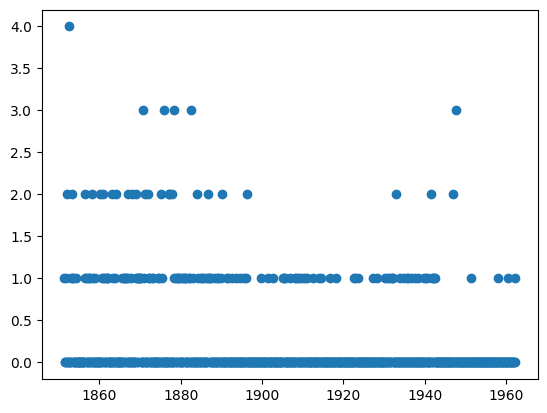

In [93]:
plt.scatter(centroids, counts)

In [95]:
D = len(centroids)

# length scale 
ls = 13_516
# signal variance
s_f = 1

kernel_rbf = lambda x, y: s_f**2 * jnp.exp(-0.5 * jnp.linalg.norm(x - y)**2 / ls**2)

kernel_rbf = jax.jit(kernel_rbf)

kernel_matrix = jax.vmap(jax.vmap(kernel_rbf, in_axes=(None, 0)), in_axes=(0, None))(centroids, centroids)+ 1e-6*np.eye(D)

In [120]:
y = counts
m = np.log(191/811) 
z = jnp.zeros(D)

def lp(z):
    # global variables: data y, prior kernel_matrix
    lp = jspy.stats.multivariate_normal.logpdf(z, mean=jnp.zeros(D), cov=kernel_matrix)
    lp += jspy.stats.poisson.logpmf(y, jnp.exp(z + m)).sum()
    #lp += jspy.stats.multivariate_normal.logpdf(y, mean=z, cov=0.1*jnp.eye(D)).sum()
    return lp

lp_g = jax.jit(jax.grad(lp, argnums=0))

lp_vmap = lambda x: jax.vmap(lp, in_axes=0)(x)
lp_g_vmap = lambda x: jax.vmap(lp_g, in_axes=0)(x)

In [ ]:
key = jr.key(1234)
#key, subkey = jr.split(key)

# log f ~ GP
g = jr.multivariate_normal(key, mean=jnp.zeros(D), cov=kernel_matrix) # + 1e-6*np.eye(D))
# Poisson rate
f = jnp.exp(g)
# observed counts
y = jr.poisson(key, lam=f)
#y = jr.multivariate_normal(key, mean=g, cov=0.01*jnp.eye(D))

In [121]:
lp(z)

Array(4346.49844184, dtype=float64)

In [98]:
alg = ADVI(D, lp_vmap)
key = jax.random.PRNGKey(2)
batch_size = 100
niter = 10_000
nprint = 10
lr = 1e-2

monitor_advi = KLMonitor(batch_size=32, ref_samples=None, checkpoint=10, store_params_iter=10)
opt = optax.adam(learning_rate=lr)

%time meanfit_advi, covfit_advi, losses = alg.fit(key, opt, batch_size=batch_size, niter=niter, nprint=nprint, \
                                monitor=monitor_advi)

Iteration 0 of 10000
Iteration 1000 of 10000
Iteration 2000 of 10000
Iteration 3000 of 10000
Iteration 4000 of 10000
Iteration 5000 of 10000
Iteration 6000 of 10000
Iteration 7000 of 10000
Iteration 8000 of 10000
Iteration 9000 of 10000
Iteration 10000 of 10000
CPU times: user 1h 19min 47s, sys: 44min 42s, total: 2h 4min 29s
Wall time: 11min 58s


In [129]:
ranklr = 50

batch_size = 100
niter = 10_000
pbam = PBAM(D, lp_vmap, lp_g_vmap)
key = jax.random.PRNGKey(2)
nprint = 100
regf = lambda x: D * batch_size #1000#/(1+x)


monitor_pbam = KLMonitor(batch_size=32, ref_samples=None, checkpoint=10, store_params_iter=10)

%time meanfit_pbam, psi, llambda = pbam.fit(key, rank=ranklr, batch_size=batch_size, niter=niter, \
                                  regf=regf, nprint=nprint, \
                                  tolerance=1e-4, eta=1.0, niter_em=501, \
                                  print_convergence=False, monitor=monitor_pbam)

covfit_pbam = np.diag(psi) + llambda@llambda.T


Iteration 0 of 10000. Time taken :  7.152557373046875e-06
compiled
time for first 10 iterations :  0.2569301128387451
diverging? : (best, current) :  204494489.43196818 637173923.56816
Iteration 100 of 10000. Time taken :  3.081494092941284
Iteration 200 of 10000. Time taken :  5.772586107254028
Iteration 300 of 10000. Time taken :  8.467005014419556
Iteration 400 of 10000. Time taken :  11.182809829711914
Iteration 500 of 10000. Time taken :  13.93879508972168
Iteration 600 of 10000. Time taken :  16.668086051940918
Iteration 700 of 10000. Time taken :  19.38068699836731
Iteration 800 of 10000. Time taken :  22.163388967514038
Iteration 900 of 10000. Time taken :  24.91333508491516
Iteration 1000 of 10000. Time taken :  27.69161605834961
Iteration 1100 of 10000. Time taken :  30.423686981201172
Iteration 1200 of 10000. Time taken :  33.2051100730896
Iteration 1300 of 10000. Time taken :  36.02808880805969
Iteration 1400 of 10000. Time taken :  38.78193211555481
Iteration 1500 of 10000

Text(0.5, 0, '# gradient evals')

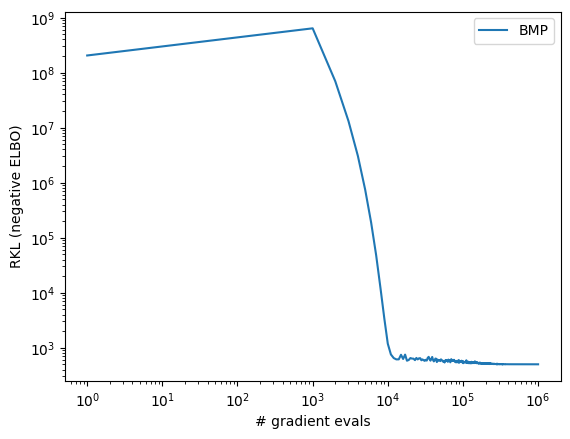

In [130]:
#plt.plot(monitor_advi.nevals, monitor_advi.rkl, label="ADVI")

#plt.plot(monitorbam.nevals, monitorbam.rkl, label="BaM")

plt.plot(monitor_pbam.nevals, monitor_pbam.rkl, label="BMP")
plt.loglog()

plt.legend()

plt.ylabel("RKL (negative ELBO)"); plt.xlabel("# gradient evals")

In [ ]:
alg = ADVI(D, lp_vmap)
key = jax.random.PRNGKey(2)
batch_size = 100
niter = 10_000
nprint = 10
lr = 1e-2

monitor_advi = KLMonitor(batch_size=32, ref_samples=None, checkpoint=10, store_params_iter=10)
opt = optax.adam(learning_rate=lr)

%time meanfit_advi, covfit_advi, losses = alg.fit(key, opt, batch_size=batch_size, niter=niter, nprint=nprint, \
                                monitor=monitor_advi)

Text(0.5, 0, 'Time')

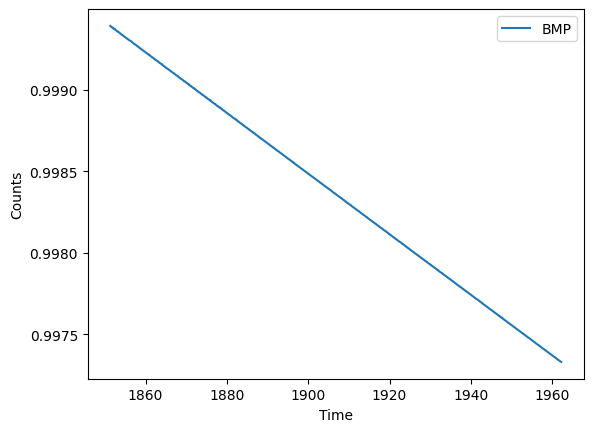

In [131]:
#plt.plot(xlim, f, label="true rate", c="gray")
#plt.scatter(xlim, y, label="data", c="gray")
#plt.plot(xlim, jnp.exp(samples_ess[20_000:].mean(0)))
#plt.scatter(centroids, counts)

#plt.plot(centroids, jnp.exp(meanfit_advi), label="ADVI")
#plt.plot(centroids, jnp.exp(meanfit_bam), label="BaM")
plt.plot(centroids, jnp.exp(meanfit_pbam), label="BMP")

plt.legend()

plt.ylabel("Counts"); plt.xlabel("Time")

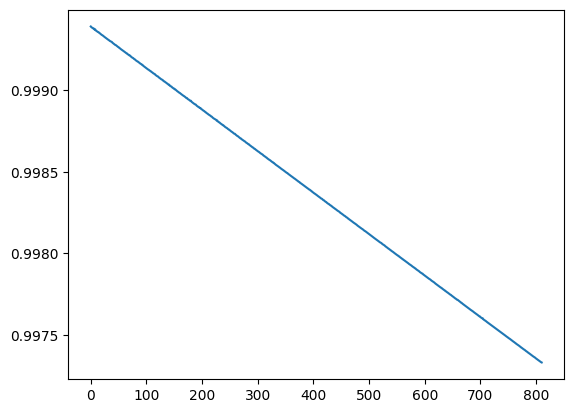

In [133]:
plt.plot( jnp.exp(meanfit_pbam))